In [1]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import sem

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

# File to Load (Remember to Change These)
mouse_drug_data_to_load = "data/mouse_drug_data.csv"
clinical_trial_data_to_load = "data/clinicaltrial_data.csv"

# Read the Mouse and Drug Data and the Clinical Trial Data
clinical_trial_df = pd.read_csv(clinical_trial_data_to_load)
mouse_drug_df = pd.read_csv(mouse_drug_data_to_load)

In [2]:
# Take a look at the Clinical Trial Data
clinical_trial_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,0,45.0,0
1,f932,0,45.0,0
2,g107,0,45.0,0
3,a457,0,45.0,0
4,c819,0,45.0,0


In [3]:
# Take a look at the Mouse Drug Data
mouse_drug_df.head(2)

,Mouse ID,Drug
0,f234,Stelasyn
1,x402,Stelasyn


In [4]:
# Combine the data into a single dataset
mouse_cancer_study = pd.merge(clinical_trial_df,mouse_drug_df,on = "Mouse ID")

# Display the data table for preview
mouse_cancer_study.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug
0,b128,0,45.000000,0,Capomulin
1,b128,5,45.651331,0,Capomulin
2,b128,10,43.270852,0,Capomulin
3,b128,15,43.784893,0,Capomulin
4,b128,20,42.731552,0,Capomulin


In [5]:
# Look at Data Types for each column
mouse_cancer_study.dtypes

Mouse ID               object
Timepoint               int64
Tumor Volume (mm3)    float64
Metastatic Sites        int64
Drug                   object
dtype: object

In [6]:
# Check data
mouse_cancer_study["Tumor Volume (mm3)"].agg(["min","max","mean"])
mouse_cancer_study["Metastatic Sites"].agg(["min","max","mean"])
mouse_cancer_study["Timepoint"].agg(["min","max","mean"])
mouse_cancer_study["Mouse ID"].value_counts()
# Mouse g989 has more than double the data of any other
mouse_cancer_study.loc[mouse_cancer_study["Mouse ID"] == "g989" ,:].head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug
860,g989,0,45.000000,0,Stelasyn
861,g989,0,45.000000,0,Propriva
862,g989,0,45.000000,0,Stelasyn
863,g989,0,45.000000,0,Propriva
864,g989,5,48.786801,0,Stelasyn


In [7]:
# It looks like we have data for Stelasyn and Propriva treatments for this mouse
# We can either assume this data was for two different mice and split it or throw the data out
cancer_study = mouse_cancer_study.loc[mouse_cancer_study["Mouse ID"] != "g989" ,:]
cancer_study.head()
# Since this is just pet data and were not looking at specific mice I'm going to leave it in

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug
0,b128,0,45.000000,0,Capomulin
1,b128,5,45.651331,0,Capomulin
2,b128,10,43.270852,0,Capomulin
3,b128,15,43.784893,0,Capomulin
4,b128,20,42.731552,0,Capomulin


## Tumor Response to Treatment

In [8]:
# Store the Mean Tumor Volume Data Grouped by Drug and Timepoint 
tumor_volume_by_drug = mouse_cancer_study.groupby(by = ["Drug","Timepoint"])["Tumor Volume (mm3)"].mean().to_frame()

#reset the index to get three columns of info
tumor_volume_by_drug = tumor_volume_by_drug.reset_index()
tumor_volume_by_drug.head()


,Drug,Timepoint,Tumor Volume (mm3)
0,Capomulin,0,45.000000
1,Capomulin,5,44.266086
2,Capomulin,10,43.084291
3,Capomulin,15,42.064317
4,Capomulin,20,40.716325


In [9]:
tumor_volume_by_drug.dtypes

Drug                   object
Timepoint               int64
Tumor Volume (mm3)    float64
dtype: object

In [10]:
# Store the Standard Error of Tumor Volumes Grouped by Drug and Timepoint
tumor_standard_error = mouse_cancer_study.groupby(by = ["Drug","Timepoint"])["Tumor Volume (mm3)"].sem().to_frame()

tumor_standard_error = tumor_standard_error.reset_index()

tumor_standard_error.head()


,Drug,Timepoint,Tumor Volume (mm3)
0,Capomulin,0,0.000000
1,Capomulin,5,0.448593
2,Capomulin,10,0.702684
3,Capomulin,15,0.838617
4,Capomulin,20,0.909731


In [11]:
 # data_munging should be used on a data set with columns = ['Drug','Timepoint',...]
def data_munging(column, data_frame, timepoints = np.arange(0,46,5), formatted = {}):
    drug_list = data_frame["Drug"].unique()
    for drug in drug_list:
        result_list = ["N/A" for interval in range(len(timepoints))]
        for timepoint in timepoints:
            list_index = int(timepoint/5)
            new_frame = data_frame.loc[(data_frame["Drug"] == drug) &
                                       (data_frame["Timepoint"] == timepoint), :]
            result_list[list_index] = new_frame[column].values[0]
        formatted[drug] = result_list
    return_frame = pd.DataFrame(data = formatted, index = timepoints)
    return_frame.index.name = "Timepoint"
    return_frame = return_frame.rename_axis(mapper = "Drug", axis = 1)
    return return_frame

In [12]:
formatted_tumor_volume = data_munging("Tumor Volume (mm3)",tumor_volume_by_drug)
formatted_tumor_volume

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
5,44.266086,46.503051,47.062001,47.389175,46.796098,47.125589,47.248967,43.944859,47.527452,46.851818
10,43.084291,48.285125,49.403909,49.582269,48.694210,49.423329,49.101541,42.531957,49.463844,48.689881
15,42.064317,50.094055,51.296397,52.399974,50.933018,51.359742,51.067318,41.495061,51.529409,50.779059
20,40.716325,52.157049,53.197691,54.920935,53.644087,54.364417,53.346737,40.238325,54.067395,53.170334
25,39.939528,54.287674,55.715252,57.678982,56.731968,57.482574,55.504138,38.974300,56.166123,55.432935
30,38.769339,56.769517,58.299397,60.994507,59.559509,59.809063,58.196374,38.703137,59.826738,57.713531
35,37.816839,58.827548,60.742461,63.371686,62.685087,62.420615,60.350199,37.451996,62.440699,60.089372
40,36.958001,61.467895,63.162824,66.068580,65.600754,65.052675,63.045537,36.574081,65.356386,62.916692


In [13]:
formatted_tumor_error = data_munging("Tumor Volume (mm3)",tumor_standard_error)
formatted_tumor_error

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.448593,0.164505,0.235102,0.264819,0.202385,0.218091,0.231708,0.482955,0.239862,0.188950
10,0.702684,0.236144,0.282346,0.357421,0.319415,0.402064,0.376195,0.720225,0.433678,0.263949
15,0.838617,0.332053,0.357705,0.580268,0.444378,0.614461,0.466109,0.770432,0.493261,0.370544
20,0.909731,0.359482,0.476210,0.726484,0.595260,0.839609,0.555181,0.786199,0.621889,0.533182
25,0.881642,0.439356,0.550315,0.755413,0.813706,1.034872,0.577401,0.746991,0.741922,0.602513
30,0.934460,0.490620,0.631061,0.934121,0.975496,1.218231,0.746045,0.864906,0.899548,0.800043
35,1.052241,0.692248,0.984155,1.127867,1.013769,1.287481,1.084929,0.967433,1.003186,0.881426
40,1.223608,0.708505,1.055220,1.158449,1.118567,1.370634,1.564779,1.128445,1.410435,0.998515


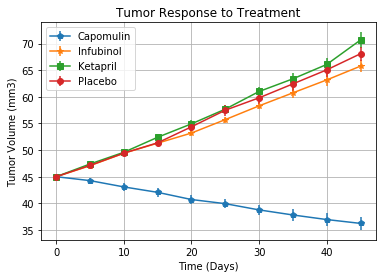

In [14]:
# Generate the Plot (with Error Bars)
drug_analysis = ['Capomulin','Infubinol','Ketapril','Placebo']
timepoints = np.arange(0,46,5)
drug_markers = {'Capomulin':"p",
                'Infubinol':"*",
                'Ketapril':"s",
                'Placebo':"o"}

for drug in drug_analysis:
    plt.errorbar(timepoints, formatted_tumor_volume[drug].values,
                 formatted_tumor_error[drug].values,
                 marker = drug_markers[drug],
                 label = drug)

plt.xlabel("Time (Days)")
plt.ylabel("Tumor Volume (mm3)")
plt.title("Tumor Response to Treatment")
plt.grid(True)
plt.legend(loc="0")
#plt.savefig


## Metastatic Response to Treatment

In [15]:
# Store the Mean Met. Site Data Grouped by Drug and Timepoint 
metastatic_site_mean = mouse_cancer_study.groupby(by = ["Drug","Timepoint"])["Metastatic Sites"].mean().to_frame()

metastatic_site_mean = metastatic_site_mean.reset_index()

metastatic_site_mean.head()

# Convert to DataFrame

# Preview DataFrame


,Drug,Timepoint,Metastatic Sites
0,Capomulin,0,0.000000
1,Capomulin,5,0.160000
2,Capomulin,10,0.320000
3,Capomulin,15,0.375000
4,Capomulin,20,0.652174


In [16]:
# Store the Standard Error associated with Met. Sites Grouped by Drug and Timepoint 

metastatic_site_error = mouse_cancer_study.groupby(by = ["Drug","Timepoint"])["Metastatic Sites"].sem().to_frame()

metastatic_site_error = metastatic_site_error.reset_index()

metastatic_site_error.head()


,Drug,Timepoint,Metastatic Sites
0,Capomulin,0,0.000000
1,Capomulin,5,0.074833
2,Capomulin,10,0.125433
3,Capomulin,15,0.132048
4,Capomulin,20,0.161621


In [17]:
# Minor Data Munging to Re-Format the Data Frames
formatted_metastatic_mean = data_munging("Metastatic Sites", metastatic_site_mean)
formatted_metastatic_mean


Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.160000,0.380952,0.280000,0.304348,0.260870,0.375000,0.320000,0.120000,0.240000,0.166667
10,0.320000,0.600000,0.666667,0.590909,0.523810,0.833333,0.565217,0.250000,0.478261,0.500000
15,0.375000,0.789474,0.904762,0.842105,0.857143,1.250000,0.764706,0.333333,0.782609,0.809524
20,0.652174,1.111111,1.050000,1.210526,1.150000,1.526316,1.000000,0.347826,0.952381,1.294118
25,0.818182,1.500000,1.277778,1.631579,1.500000,1.941176,1.357143,0.652174,1.157895,1.687500
30,1.090909,1.937500,1.588235,2.055556,2.066667,2.266667,1.615385,0.782609,1.388889,1.933333
35,1.181818,2.071429,1.666667,2.294118,2.266667,2.642857,2.300000,0.952381,1.562500,2.285714
40,1.380952,2.357143,2.100000,2.733333,2.466667,3.166667,2.777778,1.100000,1.583333,2.785714


In [18]:
formatted_metastatic_error = data_munging("Metastatic Sites", metastatic_site_error)
formatted_metastatic_error

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.074833,0.108588,0.091652,0.098100,0.093618,0.100947,0.095219,0.066332,0.087178,0.077709
10,0.125433,0.152177,0.159364,0.142018,0.163577,0.115261,0.105690,0.090289,0.123672,0.109109
15,0.132048,0.180625,0.194015,0.191381,0.158651,0.190221,0.136377,0.115261,0.153439,0.111677
20,0.161621,0.241034,0.234801,0.236680,0.181731,0.234064,0.171499,0.119430,0.200905,0.166378
25,0.181818,0.258831,0.265753,0.288275,0.185240,0.263888,0.199095,0.119430,0.219824,0.236621
30,0.172944,0.249479,0.227823,0.347467,0.266667,0.300264,0.266469,0.139968,0.230641,0.248168
35,0.169496,0.266526,0.224733,0.361418,0.330464,0.341412,0.366667,0.145997,0.240983,0.285714
40,0.175610,0.289128,0.314466,0.315725,0.321702,0.297294,0.433903,0.160591,0.312815,0.299791


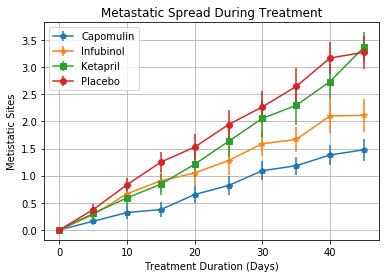

In [19]:
# Generate the Plot (with Error Bars)
drug_analysis = ['Capomulin','Infubinol','Ketapril','Placebo']
timepoints = np.arange(0,46,5)
drug_markers = {'Capomulin':"p",
                'Infubinol':"*",
                'Ketapril':"s",
                'Placebo':"o"}

for drug in drug_analysis:
    plt.errorbar(timepoints, formatted_metastatic_mean[drug].values,
                 formatted_metastatic_error[drug].values,
                 marker = drug_markers[drug],
                 label = drug)

plt.xlabel("Treatment Duration (Days)")
plt.ylabel("Metistatic Sites")
plt.title("Metastatic Spread During Treatment")
plt.grid(True)
plt.legend(loc="0")

#plt.savefig



#plt.savefig

## Survival Rates

In [20]:
# Store the Count of Mice Grouped by Drug and Timepoint (W can pass any metric)
mouse_count = mouse_cancer_study.groupby(by = ["Drug","Timepoint"])["Mouse ID"].count().to_frame().reset_index()
mouse_count.head()


,Drug,Timepoint,Mouse ID
0,Capomulin,0,25
1,Capomulin,5,25
2,Capomulin,10,25
3,Capomulin,15,24
4,Capomulin,20,23


In [21]:
# Minor Data Munging to Re-Format the Data Frames
formatted_mouse_count = data_munging("Mouse ID",mouse_count)
formatted_mouse_count


Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,25,25,25,25,25,25,26,25,26,25
5,25,21,25,23,23,24,25,25,25,24
10,25,20,21,22,21,24,23,24,23,22
15,24,19,21,19,21,20,17,24,23,21
20,23,18,20,19,20,19,17,23,21,17
25,22,18,18,19,18,17,14,23,19,16
30,22,16,17,18,15,15,13,23,18,15
35,22,14,12,17,15,14,10,21,16,14
40,21,14,10,15,15,12,9,20,12,14


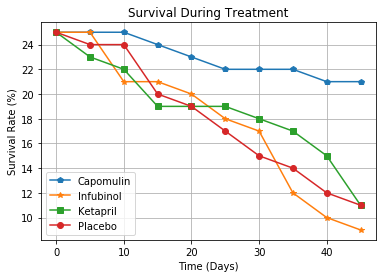

In [24]:
# Generate the Plot (with Error Bars)
drug_analysis = ['Capomulin','Infubinol','Ketapril','Placebo']
timepoints = np.arange(0,46,5)
drug_markers = {'Capomulin':"p",
                'Infubinol':"*",
                'Ketapril':"s",
                'Placebo':"o"}

for drug in drug_analysis:
    plt.errorbar(timepoints, formatted_mouse_count[drug].values,
                 marker = drug_markers[drug],
                label = drug)

    
plt.xlabel("Time (Days)")
plt.ylabel("Survival Rate (%)")
plt.title("Survival During Treatment")
plt.grid(True)
plt.legend(loc="0")


#plt.savefig

## Summary Bar Graph

In [ ]:
formatted_tumor_volume

In [26]:
# Calculate the percent changes for each drug
percent_change = {}

for drug in formatted_tumor_volume.columns:
    starting_volume = formatted_tumor_volume.loc[0,drug]
    final_volume = formatted_tumor_volume.loc[45,drug]
    percent_change[drug] = -(1 - final_volume/starting_volume) * 100

# Display the data to confirm
percent_change 

{'Capomulin': -19.475302667894155,
 'Ceftamin': 42.51649185589741,
 'Infubinol': 46.12347172785185,
 'Ketapril': 57.02879468660604,
 'Naftisol': 53.92334713476919,
 'Placebo': 51.29796048315151,
 'Propriva': 47.24117486320634,
 'Ramicane': -22.32090046276666,
 'Stelasyn': 52.085134287899,
 'Zoniferol': 46.57975086509523}

Text(2.5,10,'51.30%')

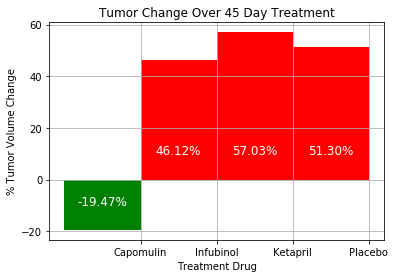

In [60]:
# Store all Relevant Percent Changes into a Tuple
drug_analysis = ['Capomulin','Infubinol','Ketapril','Placebo']
volume_reduction = [[],[]]
volume_increase = [[],[]]

for drug in drug_analysis:
    change = percent_change[drug]
    if change < 0:
        volume_reduction[0].append(drug)
        volume_reduction[1].append(change)
    else:
        volume_increase[0].append(drug)
        volume_increase[1].append(change)

plt.bar(volume_reduction[0],volume_reduction[1],color="g",align="edge",
        width = -1)
plt.bar(volume_increase[0],volume_increase[1],color="r",align="edge",
        width = -1)

plt.xlabel("Treatment Drug")
plt.ylabel("% Tumor Volume Change")
plt.title("Tumor Change Over 45 Day Treatment")
plt.grid(True)
plt.yticks(range(-20,61,20))

plt.text(-.5,-10,"-19.47%",color="w",fontsize =12,horizontalalignment='center')
plt.text(.5,10,"46.12%",color="w",fontsize =12,horizontalalignment='center')
plt.text(1.5,10,"57.03%",color="w",fontsize =12,horizontalalignment='center')
plt.text(2.5,10,"51.30%",color="w",fontsize =12,horizontalalignment='center')
# Save the Figure
#plt.savefig

# Show the Figure
#fig.show()